In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
import warnings
plt.rcParams["figure.dpi"] = 100

### Basic Model
We began development of our cancer model with a simple logistic growth ODE.

In [ ]:
def dN(t, N):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  return alpha/v*N*(1-(N/k)**v)

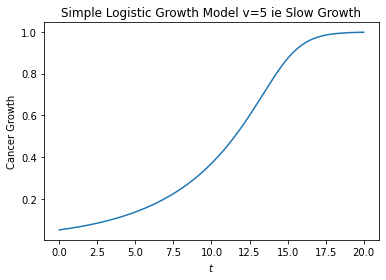

In [ ]:
#Initialization of parameters
alpha = 1
k = 1
v = 5

#Initialization of different spaces over which to solve
n0 = np.array([.05])
t0 = 0
tf = 20
t=np.linspace(0,20,400)

#Use of solve_ivp to evaluate the ODE
sol = solve_ivp(dN, (t0,tf), n0, t_eval=t)

#Plotting the results
plt.plot(sol.t, sol.y[0])
plt.title("Simple Logistic Growth Model v=5 ie Slow Growth")
plt.xlabel(r"$t$")
plt.ylabel("Cancer Growth")
plt.show()

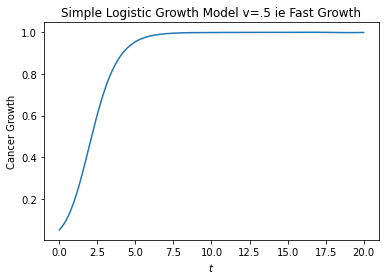

In [ ]:
#This block of code follows the same pattern as the last one but with a change of v
alpha = 1
k = 1
v = .5

n0 = np.array([.05])
t0 = 0
tf = 20
t=np.linspace(0,20,400)
sol = solve_ivp(dN, (t0,tf), n0, t_eval=t)
plt.plot(sol.t, sol.y[0])
plt.title("Simple Logistic Growth Model v=.5 ie Fast Growth")
plt.xlabel(r"$t$")
plt.ylabel("Cancer Growth")
plt.show()

By taking the limit as v -> 0 we attain the Gompertz equation. This serves as the bases for our model 

In [ ]:
def Gompertz(t,N):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  return -alpha*np.log(N/k)

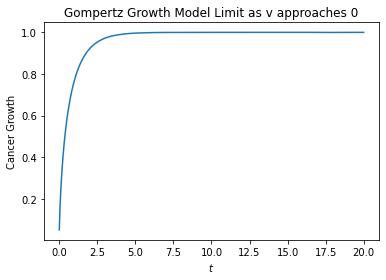

In [ ]:
#Gompertz equation solution

#Initialization of parameters
alpha = 1
k = 1

#Initialization of different spaces over which to solve
n0 = np.array([.05])
t0 = 0
tf = 20
t=np.linspace(0,20,800)
sol = solve_ivp(Gompertz, (t0,tf), n0, t_eval=t)

#Plotting the data
plt.plot(sol.t, sol.y[0])
plt.title("Gompertz Growth Model Limit as v approaches 0")
plt.xlabel(r"$t$")
plt.ylabel("Cancer Growth")
plt.show()

This code creates an animation of differing values of v.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


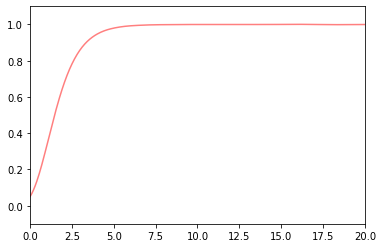

In [ ]:
#initialize initial conditions

n0 = np.array([.05])
t0 = 0
tf = 20
t=np.linspace(0,20,400)

#This u is used for storing each solution found
u = []

#Solve the ODE for each v
for j in range(100):
  v = -.999+5**(j/60)
  #print(v)
  #print(j)
  sol = solve_ivp(dN, (t0,tf), n0, t_eval=t)
  u.append(sol.y[0])

#Initialize the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((0,20))
ax.set_ylim((-.1,1.1))


traj, = plt.plot([],[], color='r',alpha=0.5)

def update(i):
    traj.set_data(sol.t,u[i])
    #return 0

#animate
ani = animation.FuncAnimation(fig, update, frames=range(100),interval=25)
plt.show()

### Applying Treatment

This is the first treatment that we apply to the cancer model. In this instance we have added an endothelial compartment for the cancer which is able to be impacted by our cancer treatment resulting in a slowing or halting of the cancer growth. In this section we develop a discussion about a bifurcation point for this binary style of treatment.

In [ ]:
#When cancer populations are above .5

def Treatment(t, N, c):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  #return -alpha*c*N-alpha*np.log(N/k)
  if N > .5:
    return c
  else:
    return 0

In [ ]:
#This modified gompertz equation takes in K as a variable as a result of endothelial growth
def Gompertz(N,K):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  return -alpha*np.log(N/K)

In [ ]:
#This is our new equation which dictates cancer growth. It factors in the presence of the endothelial compartment
#Depending on the initial conditions used it runs different versions of our cancer model such as one where cancer develops resistance to chemo

def endothelial_compartment(t, y, alpha, treatment, omega, gamma,dose=None,chemo=None,chemotime=None,Resistance_Rate=None):
    """Computes the growth of a cancer over time while accounting for the required
    growth of the endothelial compartment the tumor in which the tumor is
    enclosed.
    
    Parameters:
        chemo (bool)
        chemotime (int): counter rep since last chemo

        
    Returns:
        An ndarray corresponding to right hand side of the Predator-
            Prey model.
    """
    #If the length of the initial conditions have a length of 3 then use resistance
    if len(y) == 3:
      N,K,R = y
    #If the legth of the initial conditions is 2 then resistance is not used
    else:
      N,K = y
      R = None

    #Cancer growth via Gompertz
    eqn1 = N*Gompertz(N,K) 

    #Model without resistance
    if chemo is not None and R is None:
      chemo,ratio,chemotime = treatment(t,N,dose)
      eqn2 = -alpha*ratio*K + omega*N - gamma * N**(2/3)*K #Endothelial
    
    #Model variants with resistance
    elif R is not None:
      chemo,ratio,chemotime = treatment(t,N,dose)
      if chemo == True:
        eqn3 = Resistance_Rate*R*(1-R)
      else:
        eqn3 = 0
      eqn2 = -alpha*ratio*(1-R)*K + omega*N - gamma * N**(2/3)*K #Endothelial
      return([eqn1,eqn2,eqn3])
    elif dose is not None:
      eqn2 = -alpha*treatment(t,N,dose)*K + omega*N - gamma * N**(2/3)*K #Endothelial
    else:
      eqn2 = -alpha*treatment(t,N)*K + omega*N - gamma * N**(2/3)*K #Endothelial
    return np.array([eqn1, eqn2])

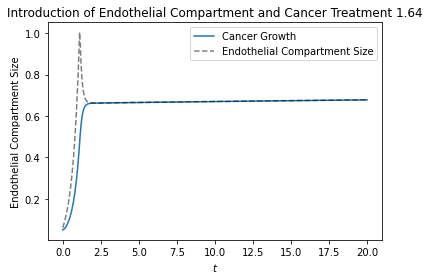

In [ ]:
#initial conditions cancer population and endothelial compartment size
ic = np.array([0.05,.06])
t0 = 0
tf = 20
tdom = np.linspace(t0,tf,400,endpoint=True)
alpha = 3
omega = 5
gamma = 0.1
doseval =1.64
sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Treatment,omega,gamma,doseval))

#Plot the result
plt.plot(sol.t,sol.y[0], label = "Cancer Growth")
plt.xlabel(r"$t$")
plt.ylabel("Growth")
plt.title("Cancer")
plt.plot(sol.t,sol.y[1], label="Endothelial Compartment Size", linestyle='--', alpha = .5, color="black")
plt.xlabel(r"$t$")
plt.ylabel("Endothelial Compartment Size")
plt.title("Introduction of Endothelial Compartment and Cancer Treatment %s"%str(doseval))
plt.legend()
plt.show()

### Bifurcation Investigation

In this section we use mesh grids to examine the bifurcation point of our model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


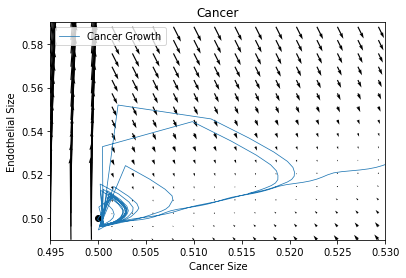

In [ ]:
#initial conditions (N,K)
ic = np.array([0.05,.06])
t0 = 0
tf = 20
tdom = np.linspace(t0,tf,400,endpoint=True)
alpha = 3
omega = 5
gamma = 0.1
doseval =1.67
sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Treatment,omega,gamma,doseval))

#Use of a treatment mesh for the arrows
def TreatmentMesh(t, N, c):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  #return -alpha*c*N-alpha*np.log(N/k)
  return (N > .5) * c

#Initialize the mesh
Y1, Y2 = np.meshgrid(np.linspace(.495, .53, 50), np.linspace(.49, .59, 50))
dU, dV = endothelial_compartment(t0,[Y1,Y2],alpha,TreatmentMesh,omega,gamma,doseval)
Q = plt.quiver(Y1[::3, ::3], Y2[::3, ::3], dU[::3, ::3], dV[::3, ::3],scale = 10)

#Plot the results
plt.plot(sol.y[0],sol.y[1], label = "Cancer Growth",linewidth = .75)
plt.xlabel(r"Cancer Size")
plt.ylabel("Endothelial Size")
plt.xlim((0.495,.53))
plt.ylim((.49,.59))
plt.scatter([.5],[.5],marker ='o',c='Black')
plt.title("Cancer")
'''plt.plot(sol.t,sol.y[1], label="Endothelial Compartment Size", linestyle='--', alpha = .5, color="black")
plt.xlabel(r"$t$")
plt.ylabel("Endothelial Compartment Size")
plt.title("Introduction of Endothelial Compartment and Cancer Treatment %s"%str(doseval))'''
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


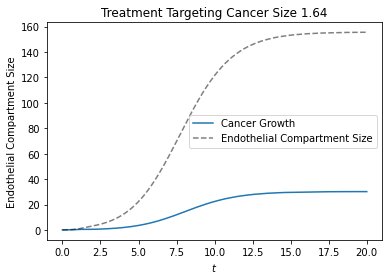

In [ ]:
def treatment_on_cancer(t, y, alpha, treatment, omega, gamma,dose=None,chemo=None,chemotime=None):
    """Computes the growth of a cancer over time while accounting for the required
    growth of the endothelial compartment the tumor in which the tumor is
    enclosed.
    
    Parameters:
        chemo (bool)
        chemotime (int): counter rep since last chemo

        
    Returns:
        An ndarray corresponding to right hand side of the Predator-
            Prey model.
    """

    if len(y) == 3:
      N,K,R = y
    else:
      N,K = y
      R = None
    
    #Endothelial
    eqn2 = omega*N - gamma * N**(2/3)*K

    if chemo is not None:
      chemo,ratio,chemotime = treatment(t,N)
      eqn1 = N*Gompertz(N,K) - alpha*ratio*N #Cancer
      #eqn2 = -alpha*ratio*N + omega*N - gamma * N**(2/3)*K
    elif dose is not None:
      eqn1 = N*Gompertz(N,K) - alpha*treatment(t,N,dose)*N #Cancer
      #eqn2 = -alpha*treatment(t,N,dose)*N + omega*N - gamma * N**(2/3)*K
    elif R is not None:
      eqn1 = N*Gompertz(N,K) - alpha*treatment(t,N,dose,R)*N #Cancer
      #eqn2 = -alpha*treatment(t,N,dose,R)*N + omega*N - gamma * N**(2/3)*K
    else:
      eqn1 = N*Gompertz(N,K) - alpha*treatment(t,N)*N #Cancer
      #eqn2 = -alpha*treatment(t,N)*N + omega*N - gamma * N**(2/3)*K
    return np.array([eqn1, eqn2])

ic = np.array([0.05,.06]) #initial conditions (N,K)
t0 = 0
tf = 20
tdom = np.linspace(t0,tf,400,endpoint=True)
alpha = 3
omega = 5
gamma = 0.1
doseval =1.64
#R = n
sol = solve_ivp(treatment_on_cancer,(t0,tf),ic,t_eval=tdom,args=(alpha,Treatment,omega,gamma,doseval))


plt.plot(sol.t,sol.y[0], label = "Cancer Growth")
plt.xlabel(r"$t$")
plt.ylabel("Growth")
plt.title("Cancer")
plt.plot(sol.t,sol.y[1], label="Endothelial Compartment Size", linestyle='--', alpha = .5, color="black")
plt.xlabel(r"$t$")
plt.ylabel("Endothelial Compartment Size")
plt.title("Treatment Targeting Cancer Size %s"%str(doseval))
plt.legend()
plt.show()

### Time Controlled Treatment

Here we introduce a new treatment regime where after cancer is detected, treatment takes place for a period of time before being halted.

In [ ]:
def Timed_Treat(t, N, dose):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  global chemo
  global chemotime #
  if chemo == True:
    treattime = t-chemotime #Days since chemo
    if treattime > .25:
      chemo = False
    return chemo, dose, chemotime
  if N > .5: #Set true once over 50%
    chemo = True
    chemotime = t
  

  return chemo, 0, chemotime

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


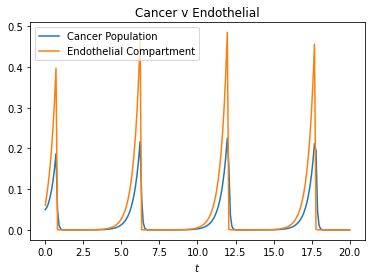

In [ ]:
#Cancer Cells do not aquire resistance to treatment

ic = np.array([0.05,.06]) #initial conditions (N,K)
t0 = 0
tf = 20
tdom = np.linspace(t0,tf,200,endpoint=True)
alpha = 3
omega = 5
gamma = 0.1
chemo = False
chemotime = 0
dose = 200
sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Timed_Treat,omega,gamma,dose,chemo,chemotime))

plt.plot(sol.t,sol.y[0],label="Cancer Population")
plt.xlabel(r"$t$")
plt.plot(sol.t,sol.y[1],label="Endothelial Compartment")
plt.title("Cancer v Endothelial")
plt.legend()
plt.savefig("TimeDose.png",dpi=640,bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


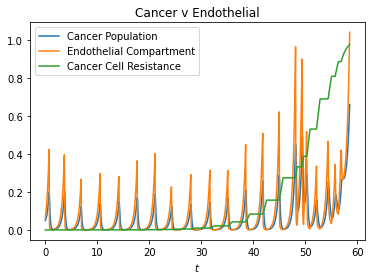

In [ ]:
#Treatment with cancer resistant cells

ic = np.array([0.05,.06,.00001]) #initial conditions (N,K)
t0 = 0
tf = 58.5
R = [.00001]
Resistance_Rate = 1
tdom, dt = np.linspace(t0,tf,800,endpoint=True, retstep=True)
alpha = 3
omega = 5
gamma = 0.1
chemo = False
chemotime = 0
dose = 20
sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Timed_Treat,omega,gamma,dose,chemo,chemotime,Resistance_Rate))

plt.plot(sol.t,sol.y[0],label="Cancer Population")
plt.xlabel(r"$t$")
plt.plot(sol.t,sol.y[1],label="Endothelial Compartment")
plt.plot(sol.t,sol.y[2], label="Cancer Cell Resistance")
plt.title("Cancer v Endothelial")
plt.legend()
plt.savefig("Resistance1.png",dpi=640,bbox_inches='tight')

### Test different parameters - constant dosage.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


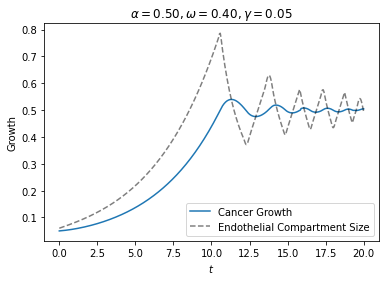

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


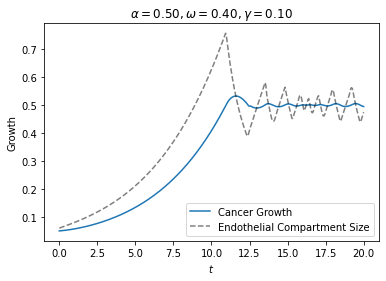

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


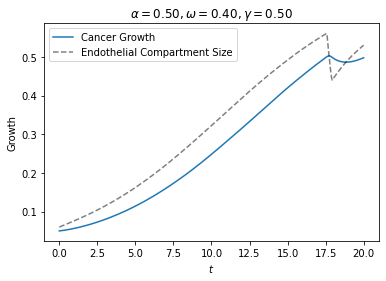

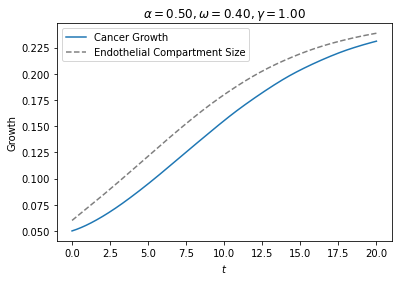

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


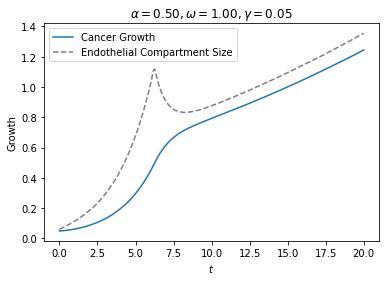

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


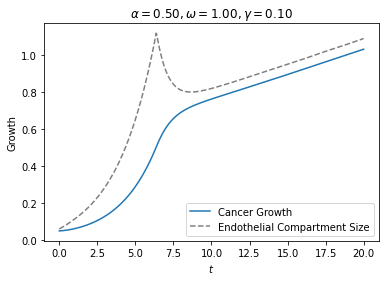

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


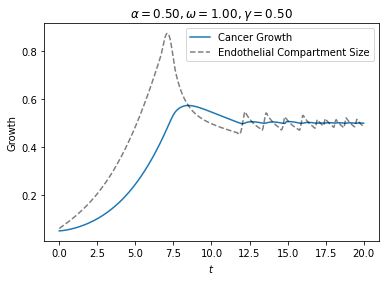

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


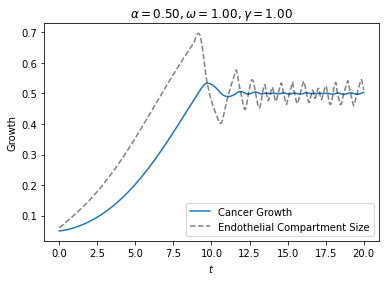

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


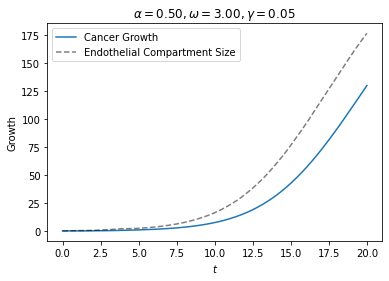

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


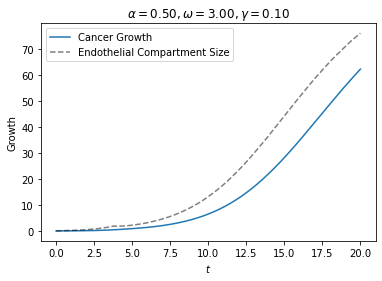

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


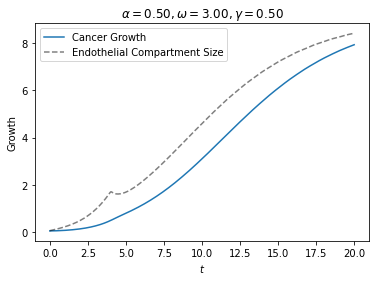

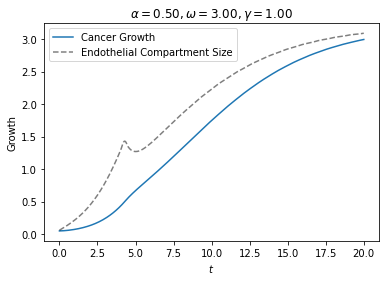

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


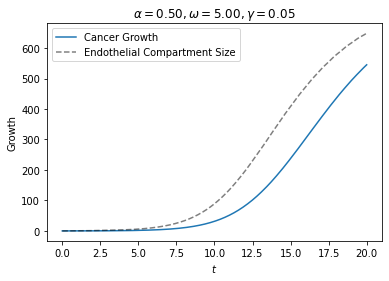

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


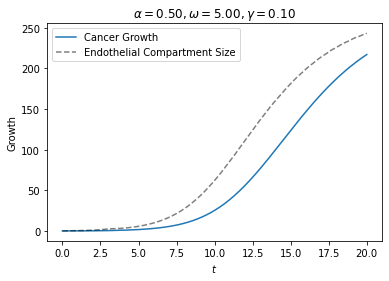

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


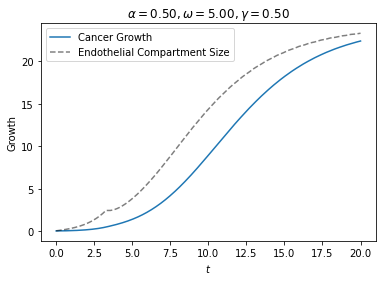

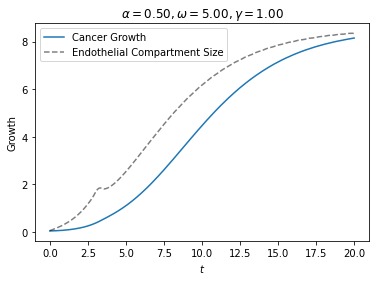

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


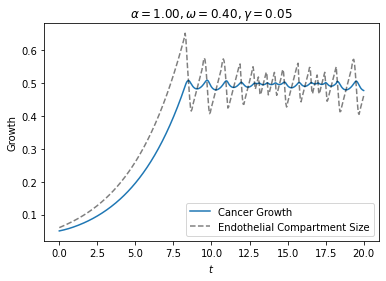

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


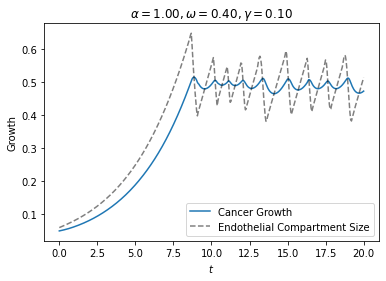

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


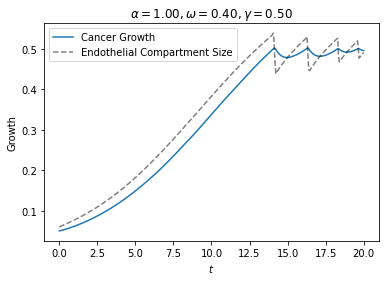

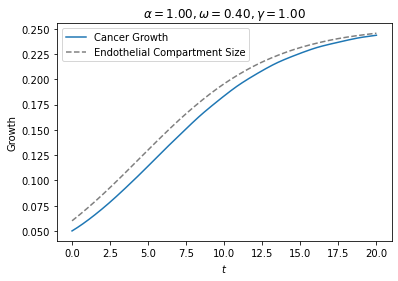

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


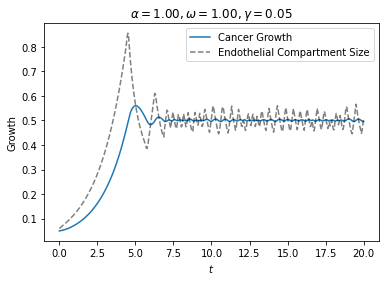

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


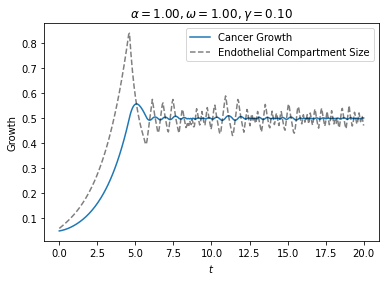

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


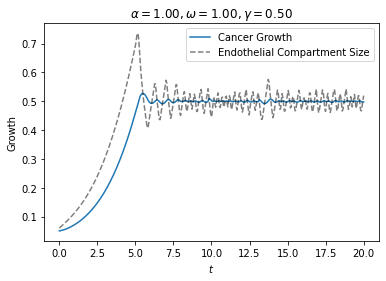

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


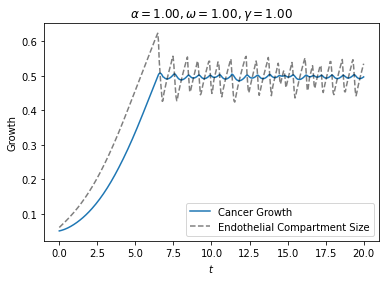

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


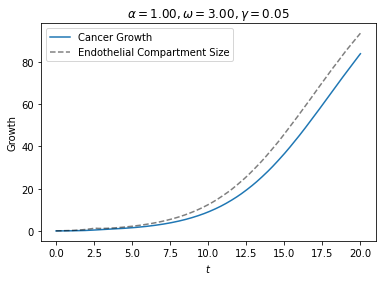

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


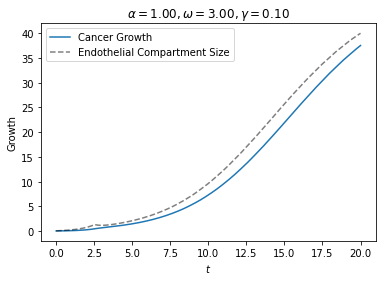

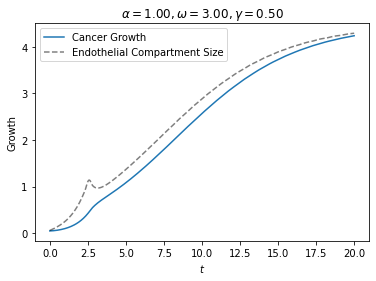

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


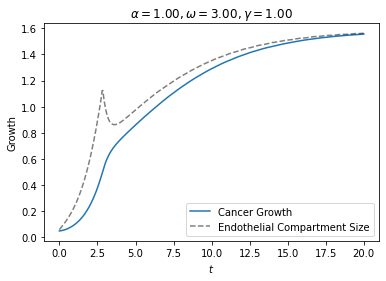

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


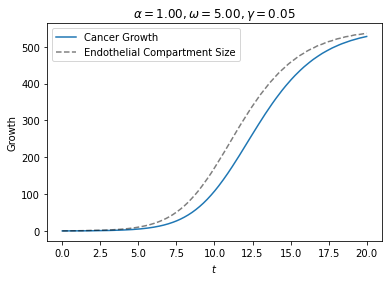

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


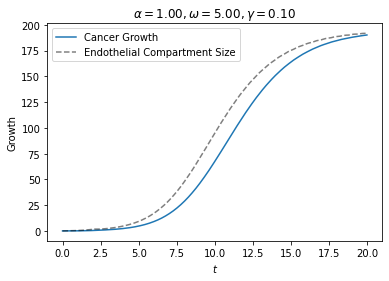

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


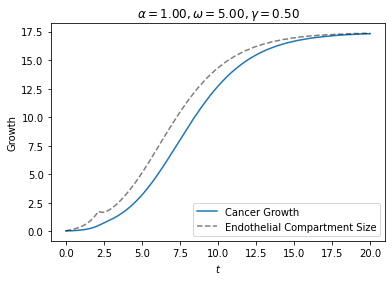

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


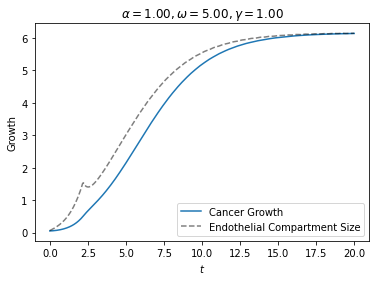

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


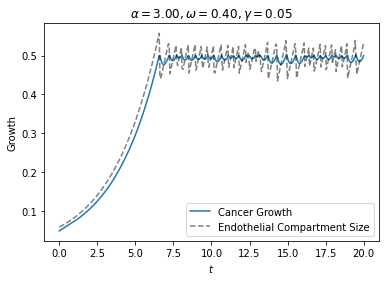

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


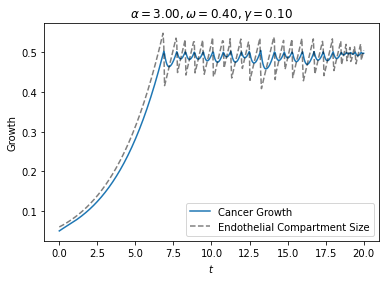

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


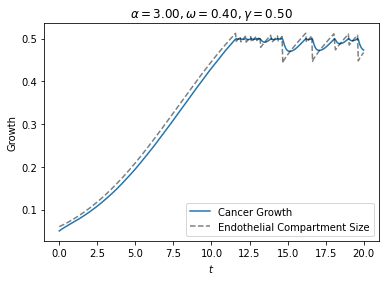

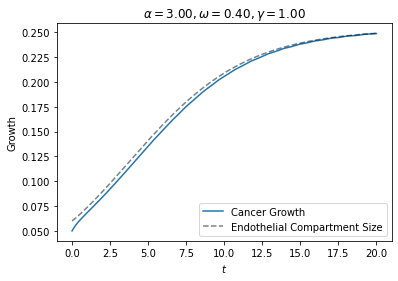

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


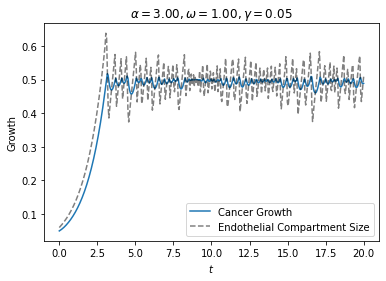

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


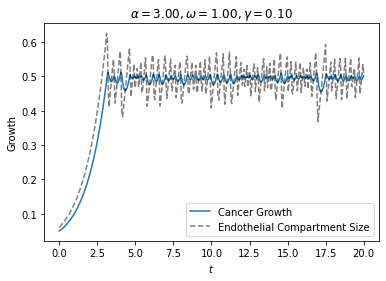

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


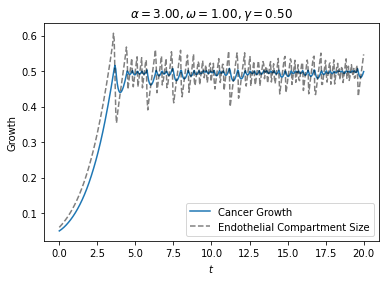

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


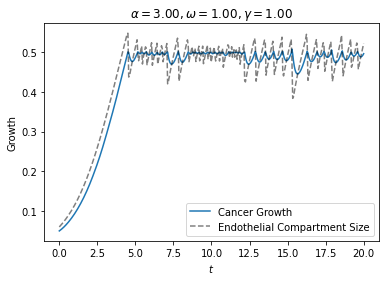

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


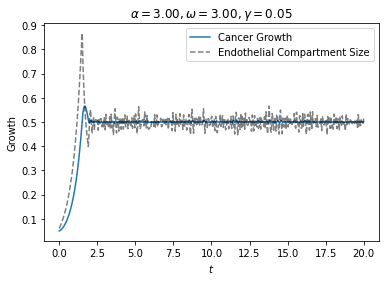

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


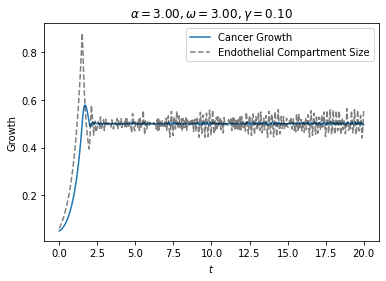

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


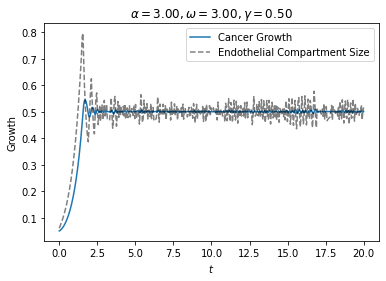

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


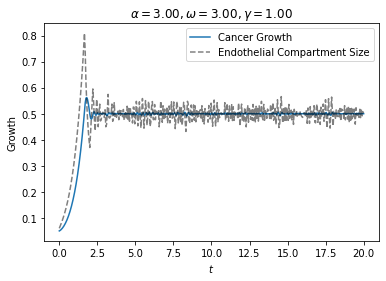

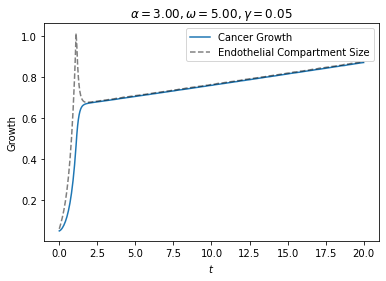

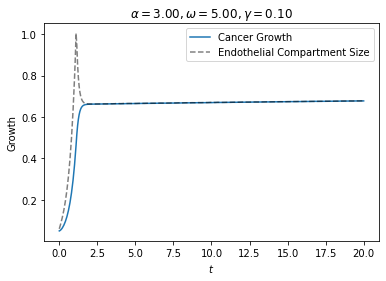

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


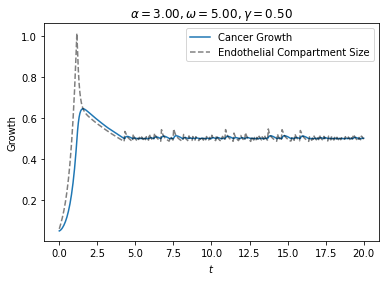

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


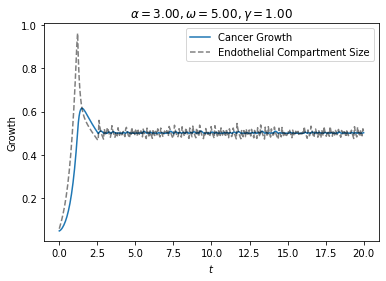

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


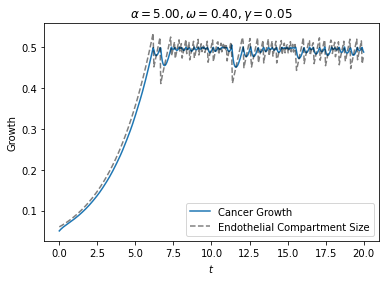

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


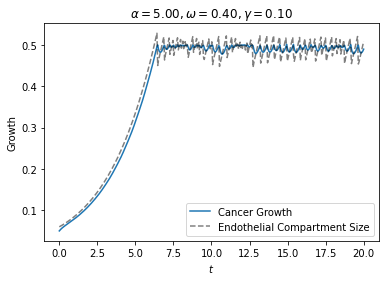

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


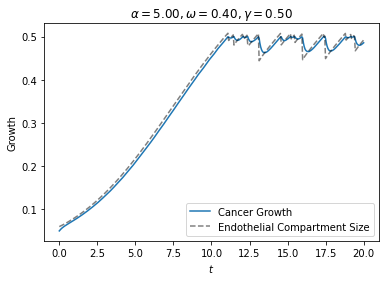

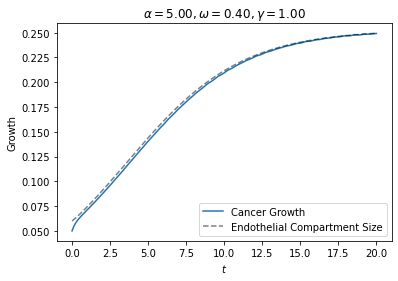

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


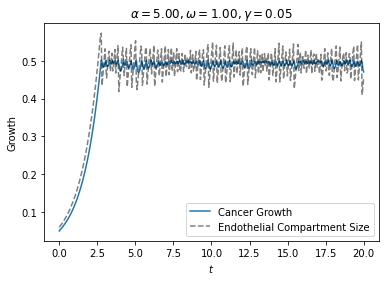

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


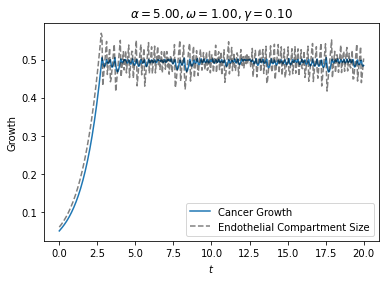

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


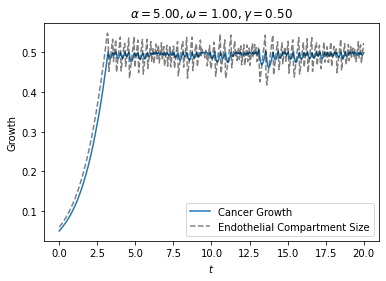

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


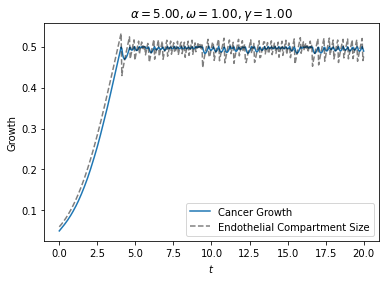

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


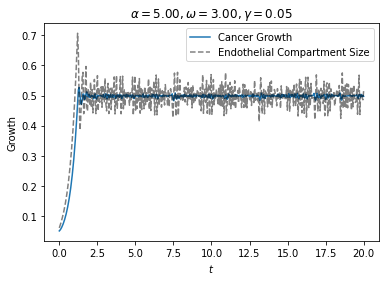

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


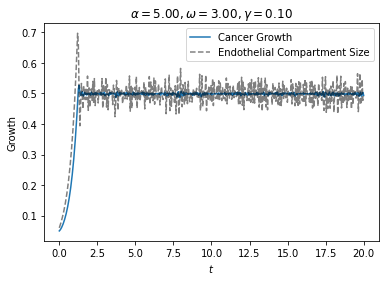

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


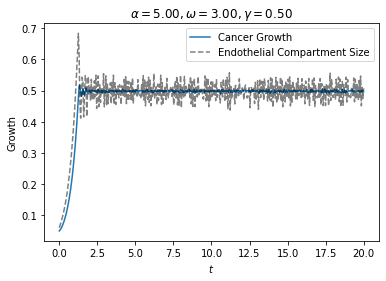

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


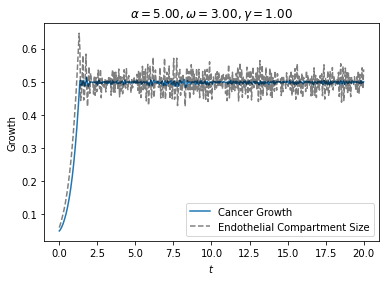

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


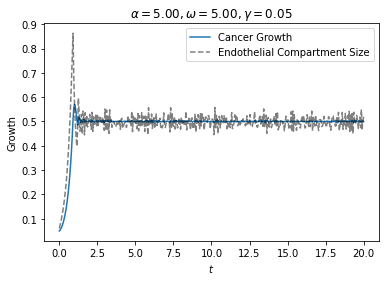

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


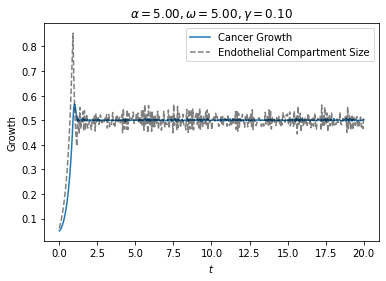

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


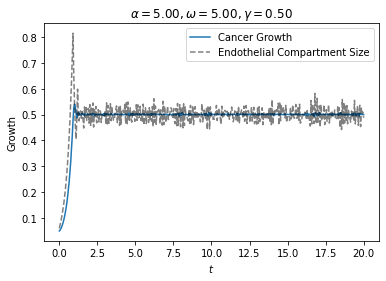

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


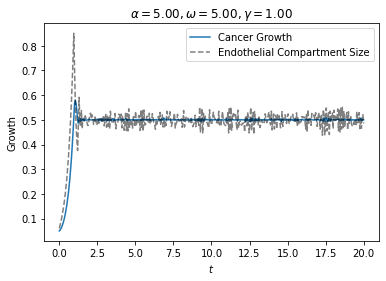

In [ ]:
ic = np.array([0.05,.06]) #initial conditions (N,K)
t0 = 0
tf = 20
tdom = np.linspace(t0,tf,400,endpoint=True)

alphaList = [.5,1,3,5] 
omegaList = [.4,1,3,5] 
gammaList = [0.05,0.1,0.5,1] 

ctr = 1

#cols = 4
#rows = 4*4
#plt.figure(figsize=(cols*2,rows*2))

for alpha in alphaList:
  for omega in omegaList:
    for gamma in gammaList:
      doseval =1.64
      sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Treatment,omega,gamma,doseval))
      plt.figure(ctr)
      plt.plot(sol.t,sol.y[0], label = "Cancer Growth")
      plt.xlabel(r"$t$")
      plt.ylabel("Growth")
      plt.plot(sol.t,sol.y[1], label="Endothelial Compartment Size", linestyle='--', alpha = .5, color="black")
      plt.title(r"$\alpha=%.2f,\omega=%.2f,\gamma=%.2f$"%(float(alpha),float(omega),gamma))
      plt.legend()
      ctr += 1
      plt.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in l

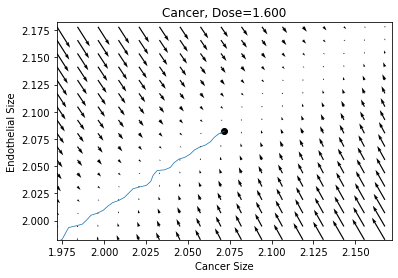

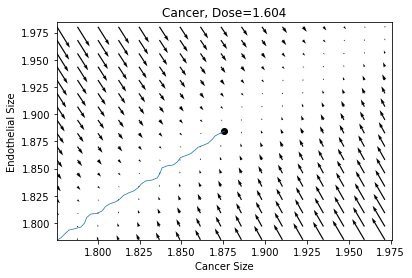

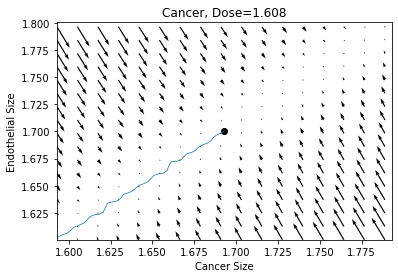

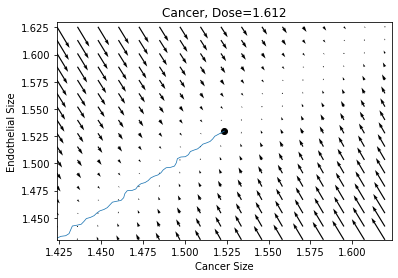

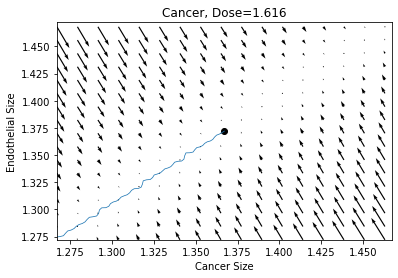

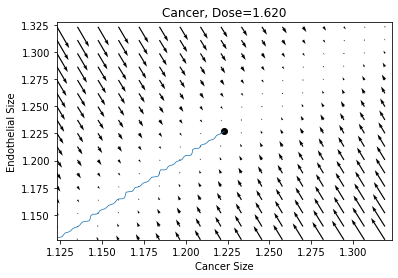

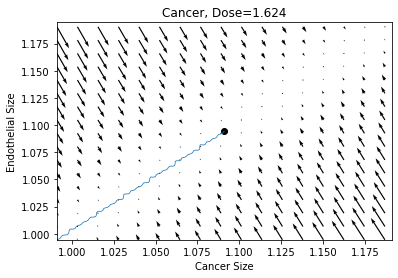

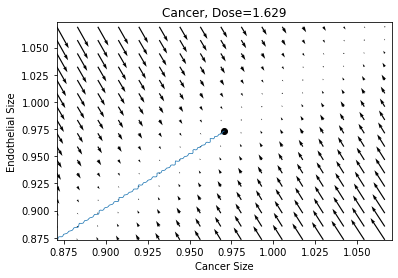

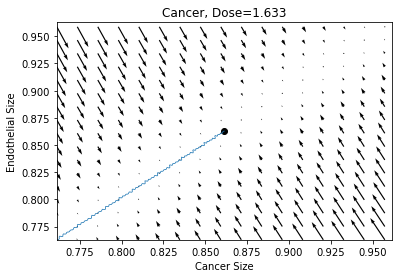

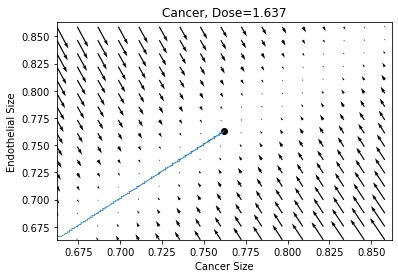

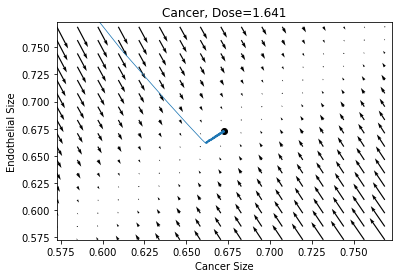

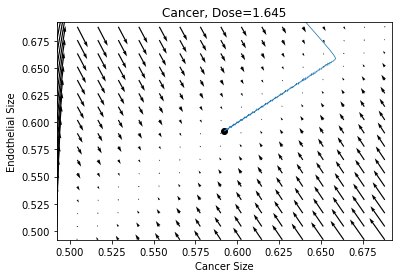

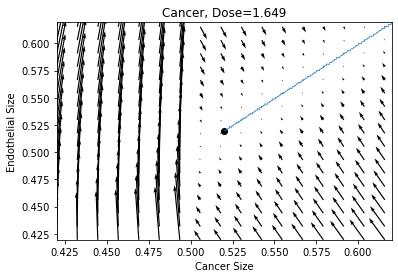

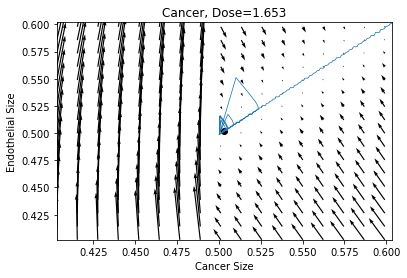

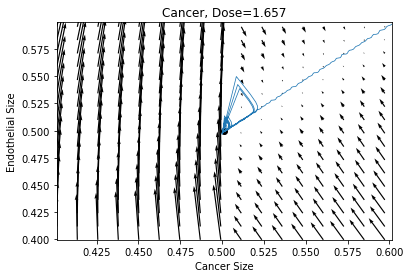

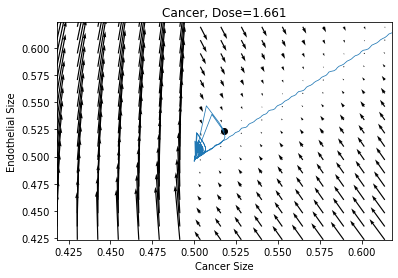

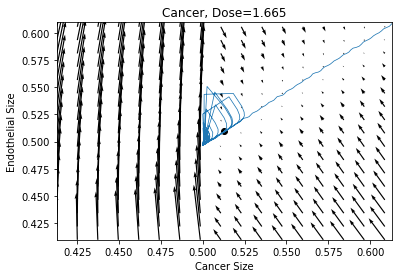

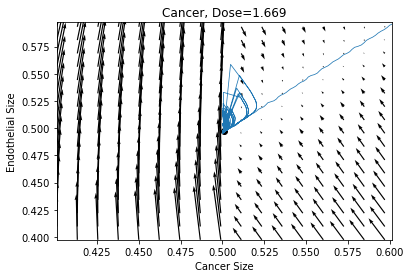

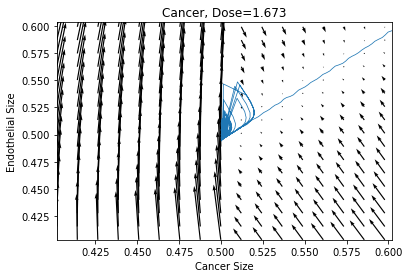

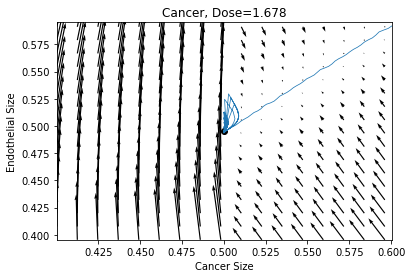

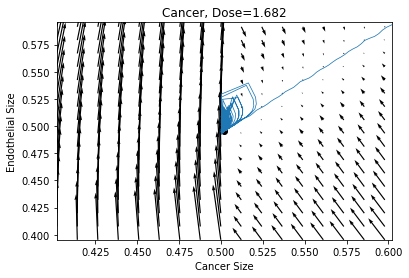

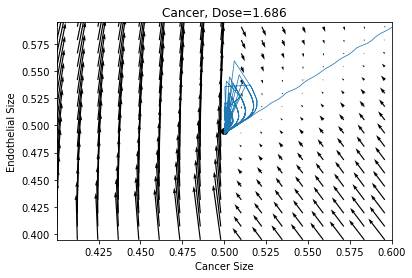

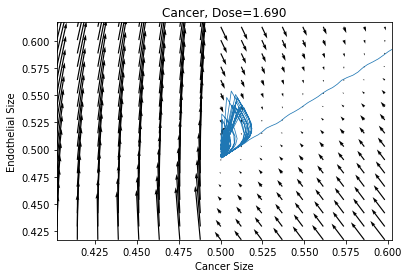

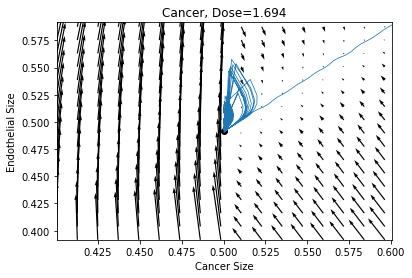

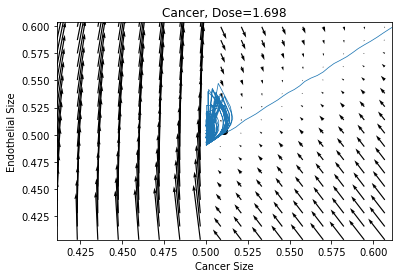

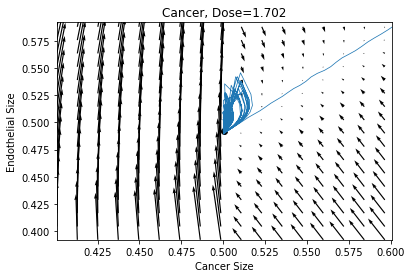

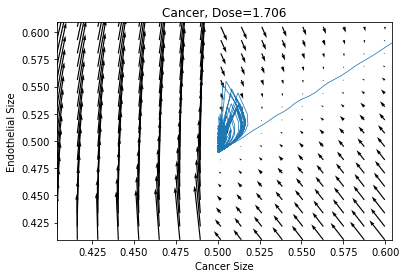

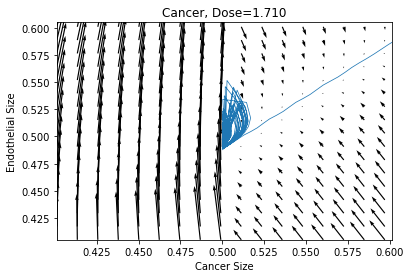

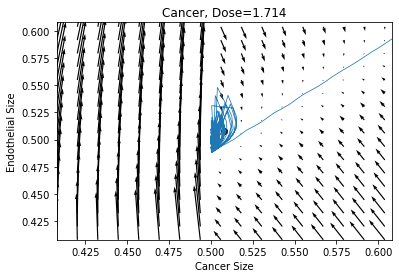

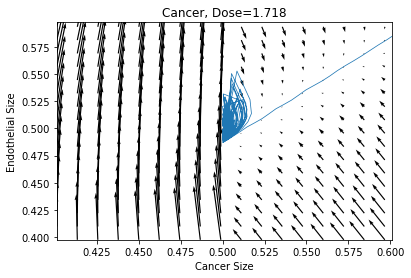

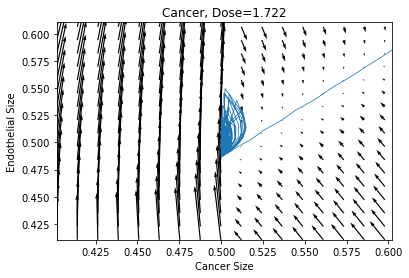

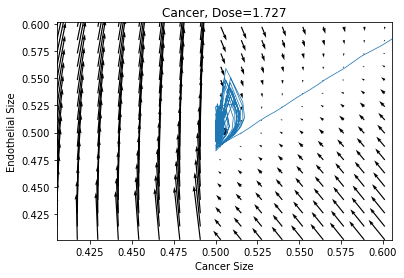

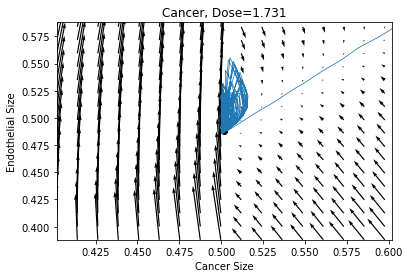

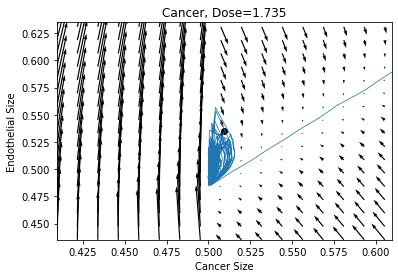

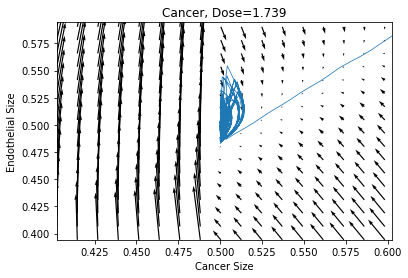

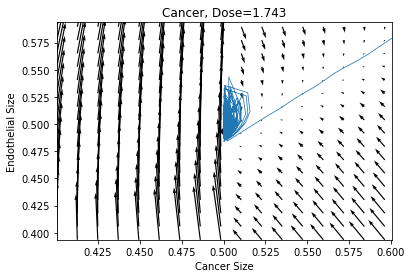

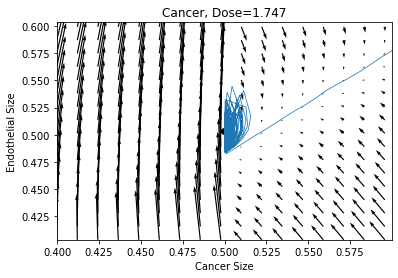

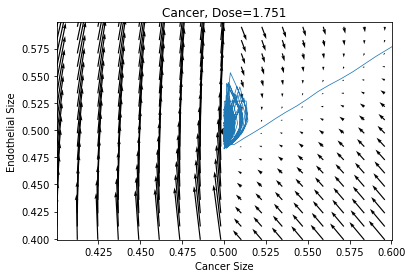

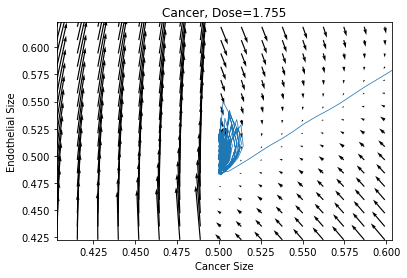

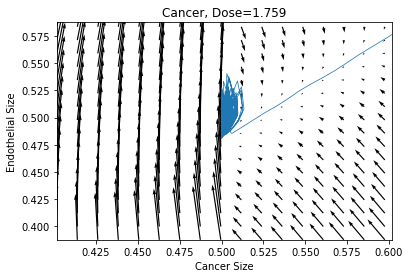

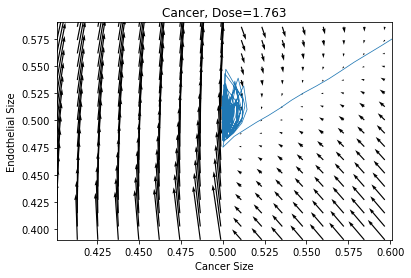

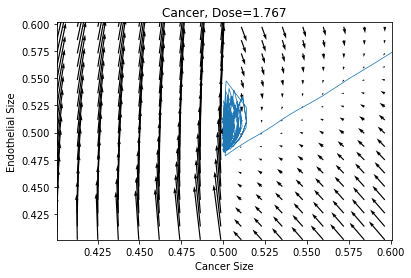

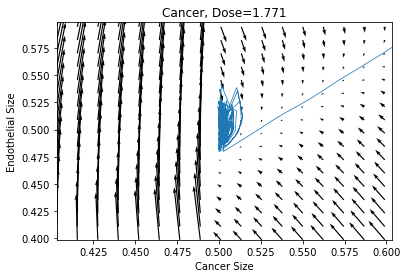

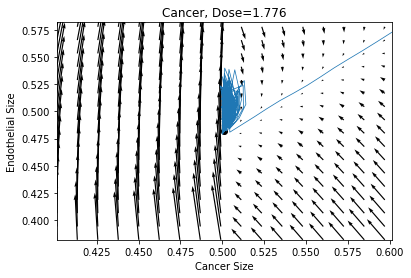

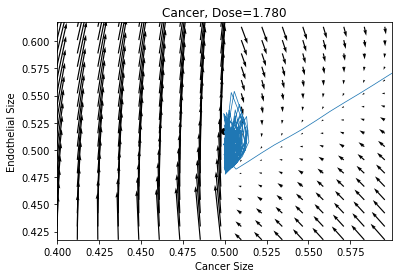

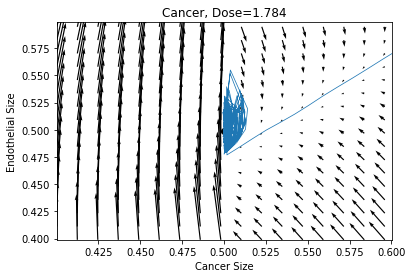

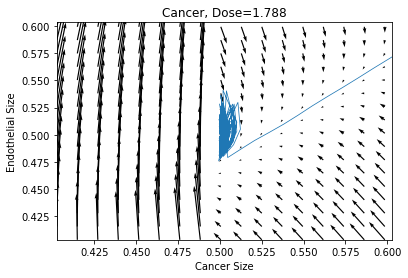

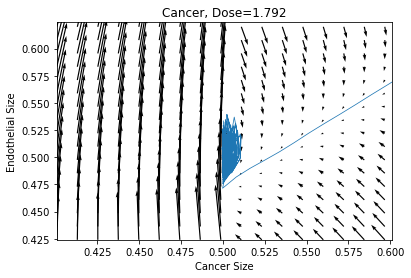

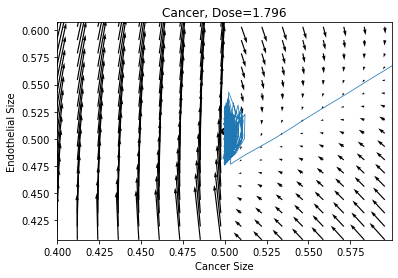

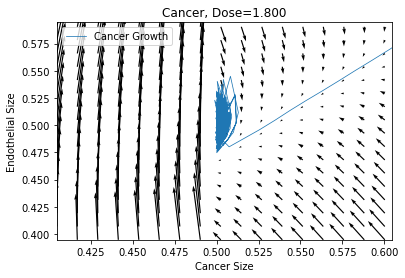

In [ ]:
ic = np.array([0.05,.06]) #initial conditions (N,K)
t0 = 0
tf = 40
tdom = np.linspace(t0,tf,400,endpoint=True)
alpha = 3
omega = 5
gamma = 0.1
doseval =1.67


def TreatmentMesh(t, N, c):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  #return -alpha*c*N-alpha*np.log(N/k)
  return (N > .5) * c

doseValList = np.linspace(1.6,1.8,50)

ctr = 1
for doseval in doseValList:
  plt.figure(ctr)
  sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Treatment,omega,gamma,doseval))
  Y1, Y2 = np.meshgrid(np.linspace(sol.y[0][-1]-.1,sol.y[0][-1]+.1, 50), np.linspace(sol.y[1][-1]-.1,sol.y[1][-1]+.1, 50))
  dU, dV = endothelial_compartment(t0,[Y1,Y2],alpha,TreatmentMesh,omega,gamma,doseval)
  Q = plt.quiver(Y1[::3, ::3], Y2[::3, ::3], dU[::3, ::3], dV[::3, ::3],scale = 15)
  plt.plot(sol.y[0],sol.y[1], label = "Cancer Growth",linewidth = .75)
  plt.xlabel(r"Cancer Size")
  plt.ylabel("Endothelial Size")
  plt.xlim((sol.y[0][-1]-.1,sol.y[0][-1]+.1))
  plt.ylim((sol.y[1][-1]-.1,sol.y[1][-1]+.1))
  plt.scatter(sol.y[0][-1],sol.y[1][-1],marker ='o',c='Black')
  plt.title("Cancer, Dose=%.3f"%doseval)
  '''plt.plot(sol.t,sol.y[1], label="Endothelial Compartment Size", linestyle='--', alpha = .5, color="black")
  plt.xlabel(r"$t$")
  plt.ylabel("Endothelial Compartment Size")
  plt.title("Introduction of Endothelial Compartment and Cancer Treatment %s"%str(doseval))'''
  ctr += 1

plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in l

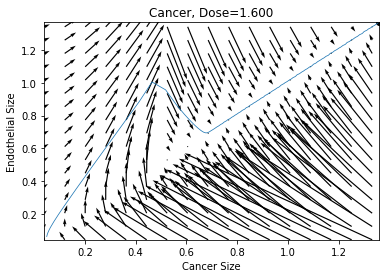

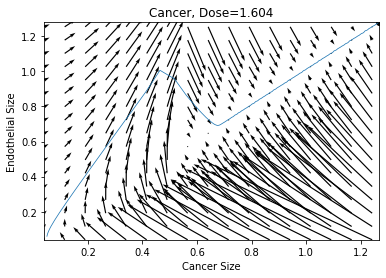

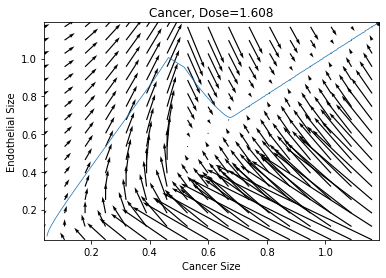

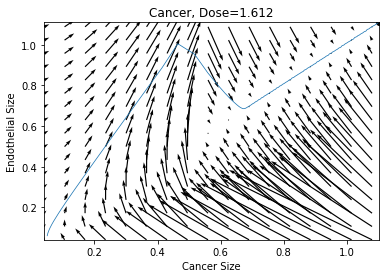

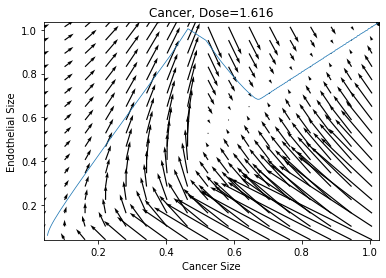

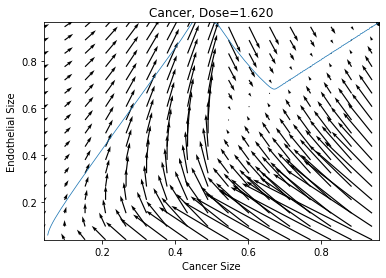

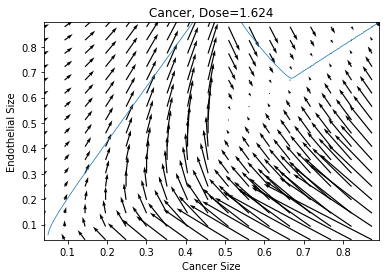

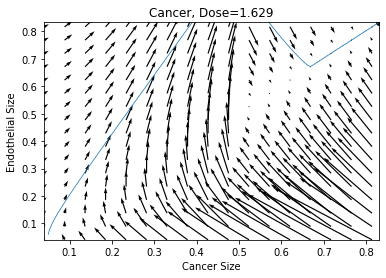

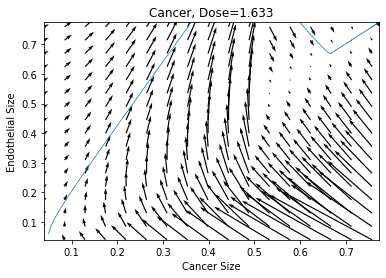

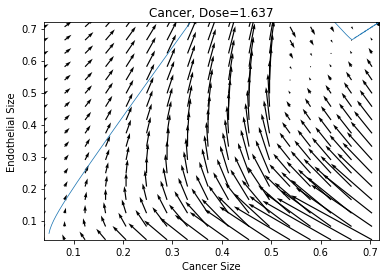

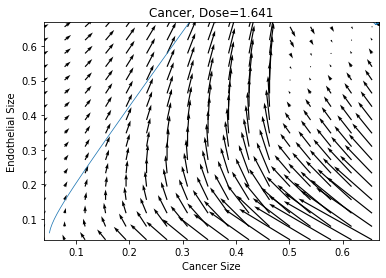

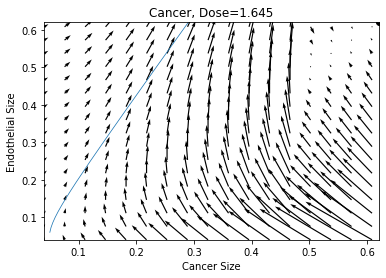

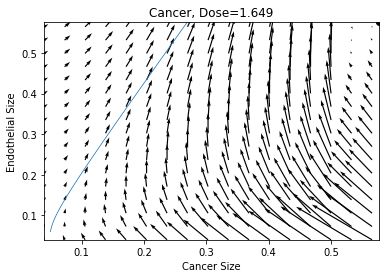

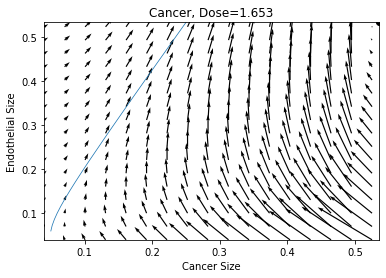

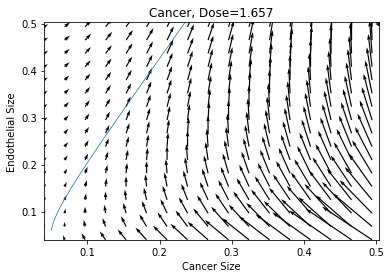

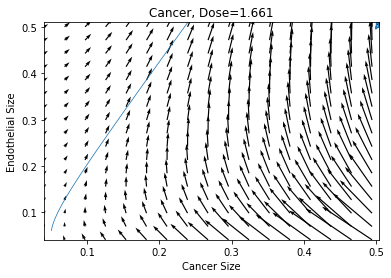

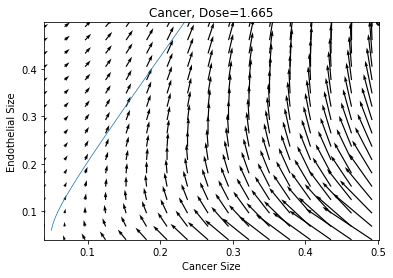

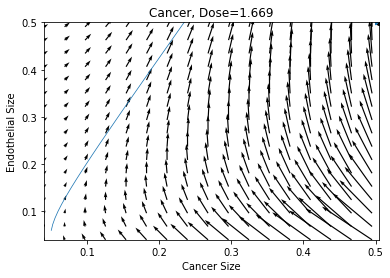

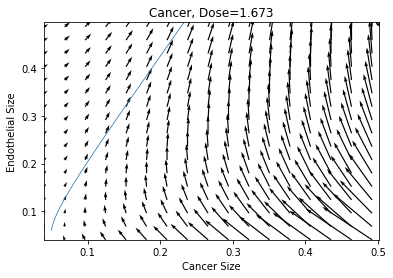

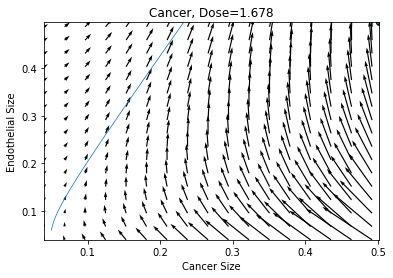

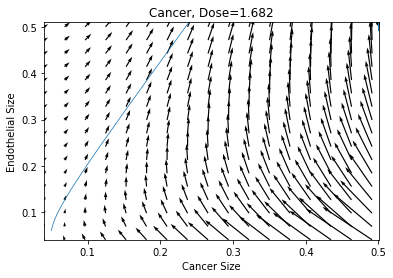

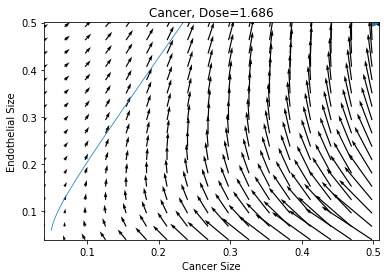

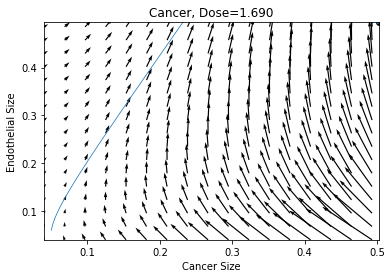

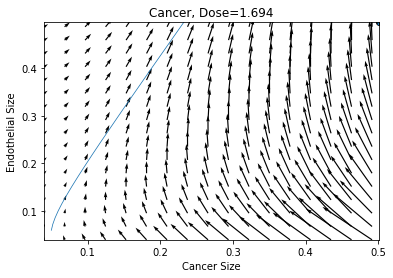

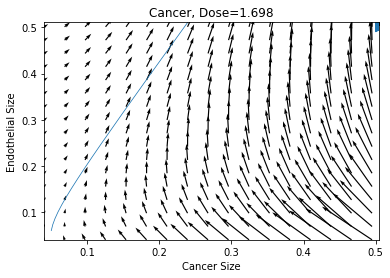

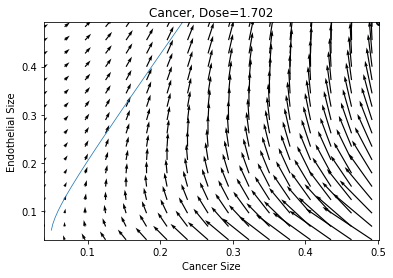

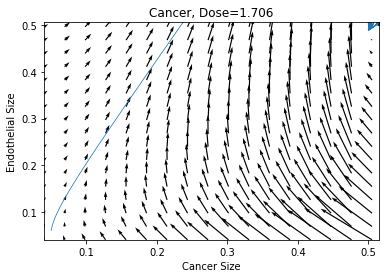

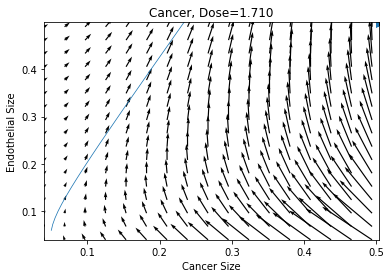

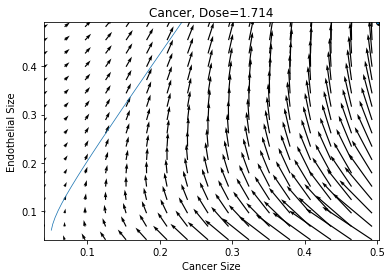

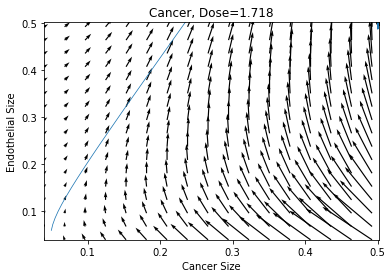

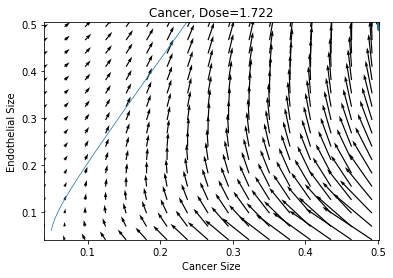

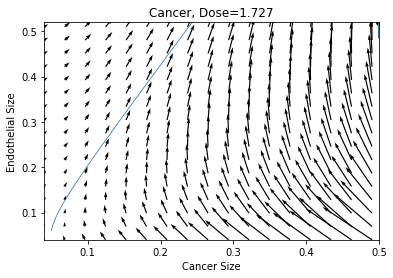

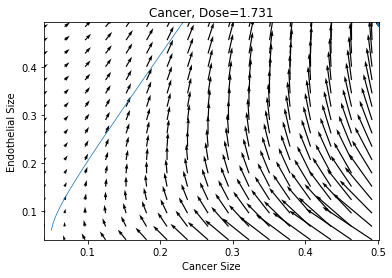

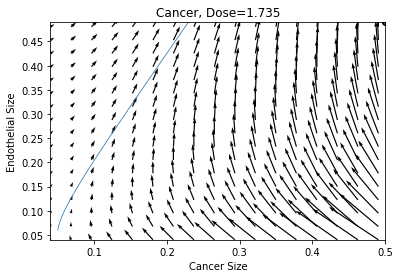

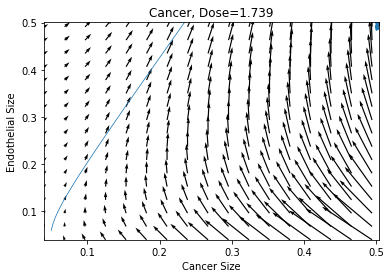

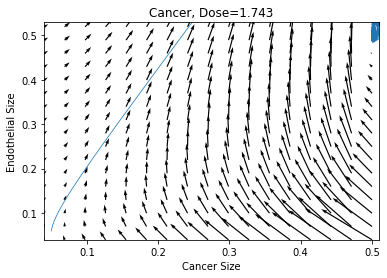

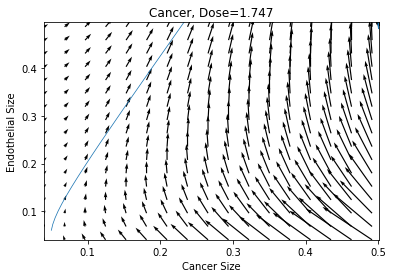

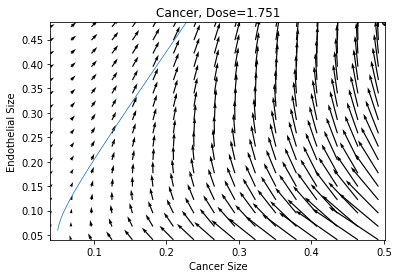

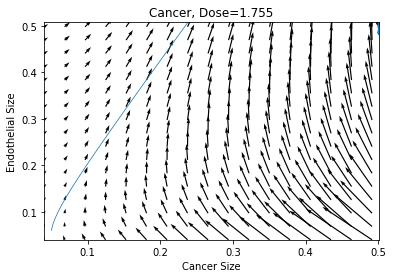

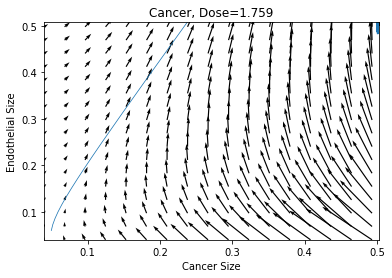

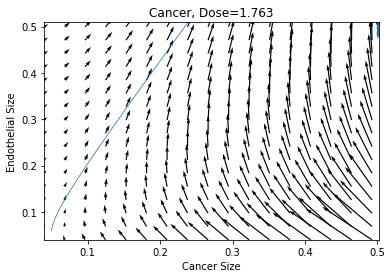

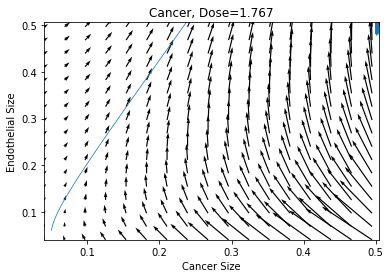

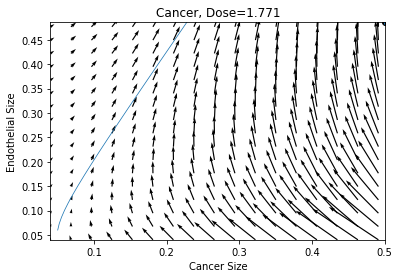

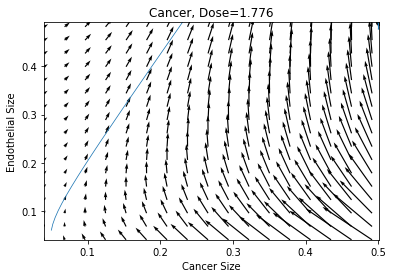

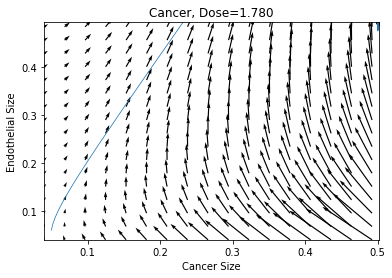

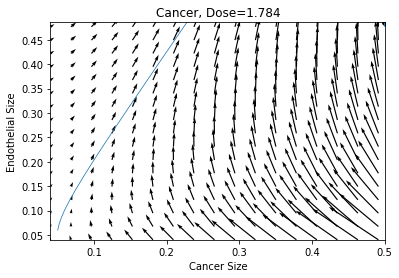

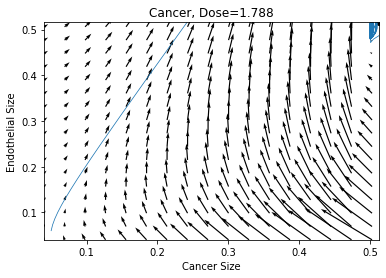

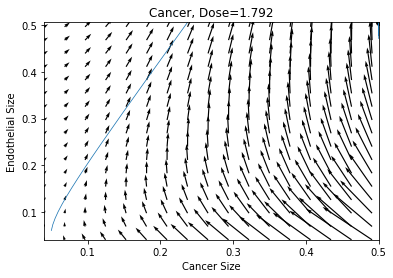

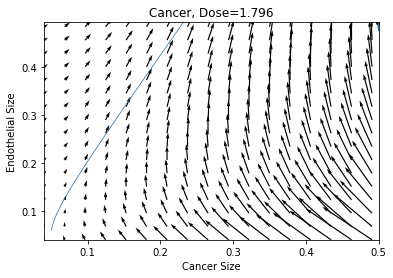

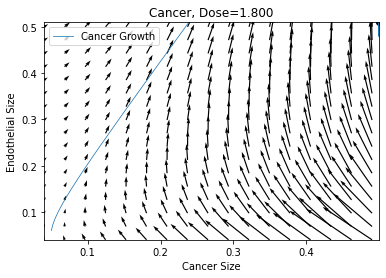

In [ ]:
ic = np.array([0.05,.06]) #initial conditions (N,K)
t0 = 0
tf = 20
tdom = np.linspace(t0,tf,400,endpoint=True)
alpha = 3
omega = 5
gamma = 0.1
doseval =1.67


def TreatmentMesh(t, N, c):
  """Simple Logistic Growth Intended to represent the growth of cancer"""
  #return -alpha*c*N-alpha*np.log(N/k)
  return (N > .5) * c

doseValList = np.linspace(1.6,1.8,50)

ctr = 1
for doseval in doseValList:
  plt.figure(ctr)
  sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Treatment,omega,gamma,doseval))
  Y1, Y2 = np.meshgrid(np.linspace(0.04,sol.y[0][-1], 50), np.linspace(0.04,sol.y[1][-1], 50))
  dU, dV = endothelial_compartment(t0,[Y1,Y2],alpha,TreatmentMesh,omega,gamma,doseval)
  Q = plt.quiver(Y1[::3, ::3], Y2[::3, ::3], dU[::3, ::3], dV[::3, ::3],scale = 25)
  plt.plot(sol.y[0],sol.y[1], label = "Cancer Growth",linewidth = .75)
  plt.xlabel(r"Cancer Size")
  plt.ylabel("Endothelial Size")
  plt.xlim((0.04,sol.y[0][-1]))
  plt.ylim((0.04,sol.y[1][-1]))
  plt.scatter(sol.y[0][-1],sol.y[1][-1],marker ='o',c='Black')
  plt.title("Cancer, Dose=%.3f"%doseval)
  '''plt.plot(sol.t,sol.y[1], label="Endothelial Compartment Size", linestyle='--', alpha = .5, color="black")
  plt.xlabel(r"$t$")
  plt.ylabel("Endothelial Compartment Size")
  plt.title("Introduction of Endothelial Compartment and Cancer Treatment %s"%str(doseval))'''
  ctr += 1

plt.legend()
plt.show()

### Treatment with cancer resistant cells

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


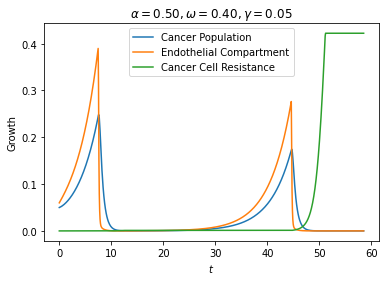

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


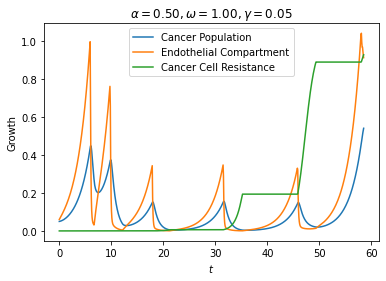

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


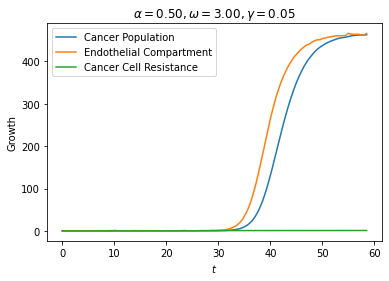

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


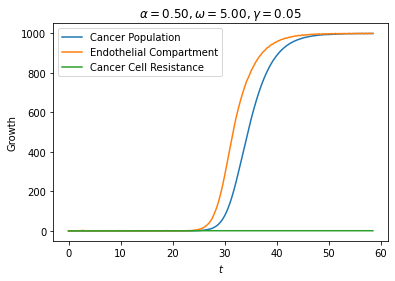

In [ ]:
#Treatment with cancer resistant cells

ic = np.array([0.05,.06,.00001]) #initial conditions (N,K)
t0 = 0
tf = 58.5
R = [.00001]
Resistance_Rate = 1
tdom, dt = np.linspace(t0,tf,800,endpoint=True, retstep=True)
alpha = 3
omega = 5
gamma = 0.1
chemo = False
chemotime = 0
dose = 20

alphaList = [.5,1,3,5] 
omegaList = [.4,1,3,5] 
gammaList = [0.05,0.1,0.5,1] 

ctr = 1

#cols = 4
#rows = 4*4
#plt.figure(figsize=(cols*2,rows*2))
alpha = 0.5
gamma = 0.05
#for alpha in alphaList:
#for gamma in gammaList:
for omega in omegaList:
  #for omega in omegaList:
    #for gamma in gammaList:
      chemo = False
      chemotime = 0
      sol = solve_ivp(endothelial_compartment,(t0,tf),ic,t_eval=tdom,args=(alpha,Timed_Treat,omega,gamma,dose,chemo,chemotime,Resistance_Rate))
      plt.figure(ctr)
      plt.plot(sol.t,sol.y[0],label="Cancer Population")
      plt.xlabel(r"$t$")
      plt.ylabel("Growth")
      plt.plot(sol.t,sol.y[1],label="Endothelial Compartment")
      plt.plot(sol.t,sol.y[2], label="Cancer Cell Resistance")
      plt.title(r"$\alpha=%.2f,\omega=%.2f,\gamma=%.2f$"%(float(alpha),float(omega),gamma))
      plt.legend()
      ctr += 1
      plt.show()

Increasing $\omega$ increases the impact that the endothelial compartment has on the growth rate of the cancer population. With greater values of $\omega$ we see that the growth rate of the cancer outpaces the treatment regime. Comparing values $\omega$ values of $0.4$ and $1.0$, we see that cancer treatments are required more frequently, causing the cancer cells to acquire resistance more rapidly.